# Swingbench Benchmark Run Comparison
The following notebook takes a number of results files generated by swingbench and analyses their results side by side. This is particulalrly useful if you are changing a specific parameter between runs i.e. cpu count, user count, sga size etc.

### Dependencies
This code requires Python 3

In [1]:
import glob
import os
import re
import time
import xml.etree.ElementTree as ET
from collections import OrderedDict

import humanize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from typing import Tuple

# get cpu count from file name. format = "results_scale<val>_uc<val>_cpu<val>.xml"
cpu_from_string = lambda s : int(re.findall('(cpu)([0-9]*)',s)[0][1])
user_count_from_string = lambda s : int(re.findall('(uc)([0-9]*)',s)[0][1])
scale_from_string = lambda s : int(re.findall('(scale)([0-9]*)',s)[0][1])
version_from_string = lambda s : int(re.findall('(ver)([0-9]*)',s)[0][1])

def get_namespace(element:ET.Element) -> str:
    m = re.match('\{.*\}', element.tag)
    return m.group(0) if m else ''

def get_key_value(element:ET.Element, section:str, key:str) -> str:
    try:
        return element.find('.//{0}{1}/{0}{2}'.format(namespace, section, key)).text
    except:
        print(f"ERROR : Can't find {section}/{key}")

def get_tx_results(doc:ET.Element, namespace:str, tx_type:str, tx_id:str) -> str:
    attrib = doc.find(".//*{0}Result[@id='{1}']/{0}{2}".format(namespace, tx_id, tx_type))
    if attrib is not None:
        return attrib.text
    else:
        return '0'

## Parameters
Change the parameters below to reflect your environment. I typically have results files that are names based on the scale, usercount and allocated CPUs.
* The first parameter `file_directory` is the directory that your results files are located in.
* The second parameter `file_wild_card` is a wild card (regular expression) string that matches files in the `file_directory`
* The third parameter `sort_function` is a python function that extracts a dimension from the filename that you want data sorted on.


In [13]:
file_directory = '/Users/dgiles/Downloads/sizeresults'
file_wild_card = 'results_scale[0-9]*_uc64_cpu8_3.xml'
sort_function = scale_from_string
sort_term = "Scale"

## Get Files

In [14]:
xmlfiles = glob.glob(os.path.join(file_directory,file_wild_card))

xmldocs = {}

for fileToParse in xmlfiles:
    tree = ET.parse(fileToParse)
    root = tree.getroot()
    namespace = get_namespace(root)
    xmldocs[os.path.basename(fileToParse)] = root
    
sortedxmldocs = OrderedDict(sorted(xmldocs.items(), key=lambda e : sort_function(e[0])))

file_df = pd.DataFrame({"Path":[os.path.abspath(f) for f in xmlfiles],
                        "Size":[humanize.naturalsize(os.path.getsize(f)) for f in xmlfiles],
                        "Created":[time.ctime(os.path.getctime(f)) for f in xmlfiles]
                       })
display(Markdown('**Processing the following files**'))
display(file_df)

pd.set_option('display.max_colwidth', None)


**Processing the following files**

,Path,Size,Created
0,/Users/dgiles/Downloads/sizeresults/results_scale1_uc64_cpu8_3.xml,29.9 kB,Wed May 31 12:11:03 2023
1,/Users/dgiles/Downloads/sizeresults/results_scale10_uc64_cpu8_3.xml,29.9 kB,Wed May 31 12:11:03 2023
2,/Users/dgiles/Downloads/sizeresults/results_scale100_uc64_cpu8_3.xml,30.6 kB,Wed May 31 12:11:03 2023
3,/Users/dgiles/Downloads/sizeresults/results_scale1000_uc64_cpu8_3.xml,30.3 kB,Wed May 31 12:11:03 2023


## Comparison of Overview Values

,results_scale1_uc64_cpu8_3.xml,results_scale10_uc64_cpu8_3.xml,results_scale100_uc64_cpu8_3.xml,results_scale1000_uc64_cpu8_3.xml
Description,,,,
BenchmarkName,"""Order Entry (PLSQL) V2""","""Order Entry (PLSQL) V2""","""Order Entry (PLSQL) V2""","""Order Entry (PLSQL) V2"""
Comment,Version 2 of the SOE Benchmark running in the database using PL/SQL,Version 2 of the SOE Benchmark running in the database using PL/SQL,Version 2 of the SOE Benchmark running in the database using PL/SQL,Version 2 of the SOE Benchmark running in the database using PL/SQL
TimeOfRun,"31 May 2023, 10:49:19","31 May 2023, 10:54:22","31 May 2023, 10:59:25","31 May 2023, 11:04:28"
TotalRunTime,0:05:00,0:05:00,0:05:00,0:05:00
TotalLogonTime,0:00:01,0:00:01,0:00:01,0:00:01
TotalCompletedTransactions,1298021,1164979,1178852,1083045
TotalFailedTransactions,0,0,0,0
AverageTransactionsPerSecond,4326.74,3883.26,3929.51,3610.15
MaximumTransactionRate,264319,237065,244873,227377


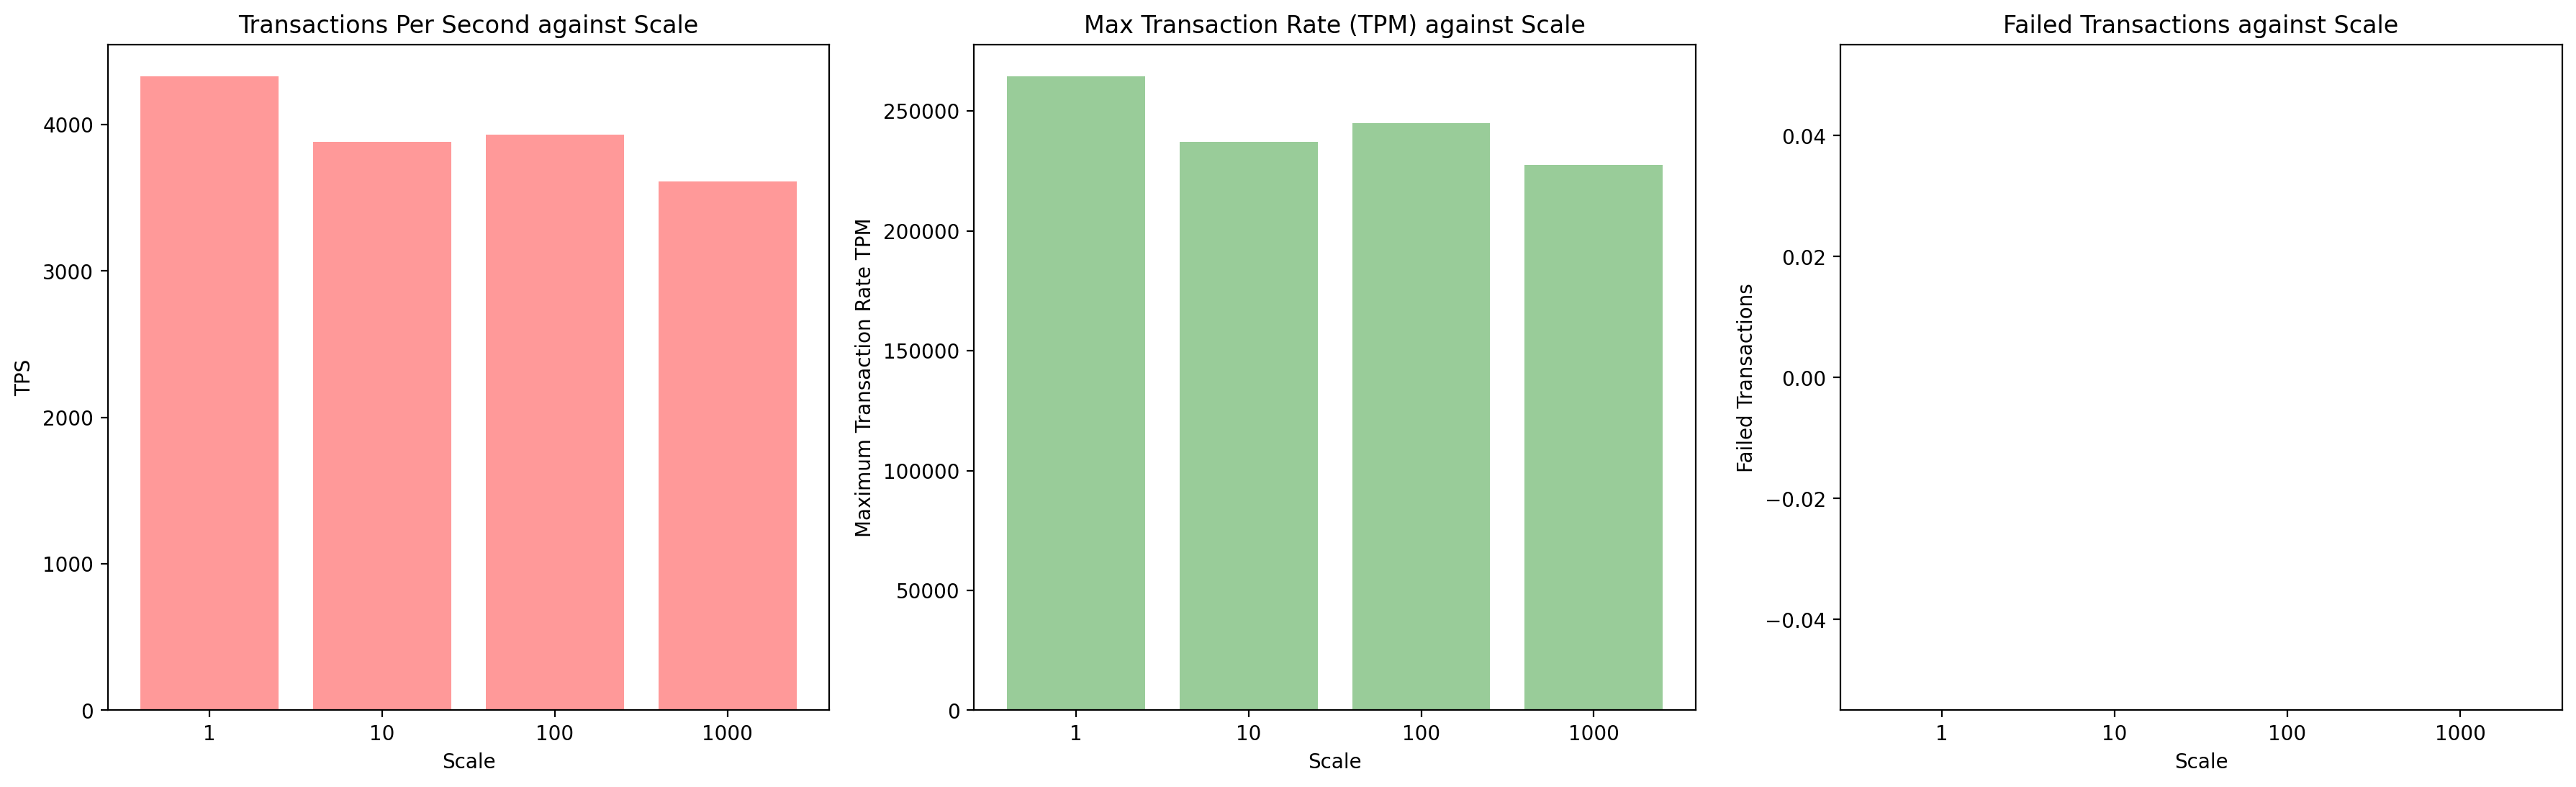

In [15]:
# Get the first doc and use it to get transactions and metric types
first_doc = list(sortedxmldocs.items())[0][1]

# Get the tags for the Overview Section
val:[ET.Element] = first_doc.findall(f".//{namespace}Overview/*")
overview_tags:[str] = [t.tag.split('}', 1)[1] for t in val]

# Format the results so they look reasonable    
table_values = {}
table_values["Description"] = overview_tags
for file_name, doc in sortedxmldocs.items():
    table_values[file_name] = [get_key_value(doc, 'Overview', key) for key in overview_tags]
overview_df = pd.DataFrame(table_values)
overview_df.set_index(['Description'],inplace=True)
display(overview_df)

# Plot the results of the tables
# cpus = [int(cpu_from_string(s)) for s in overview_df.loc['AverageTransactionsPerSecond'].index]

# measures = [int(sort_function(s)) for s in overview_df.loc['AverageTransactionsPerSecond'].index]
# forcing values to be returned as str for simpler charts
measures = [str(sort_function(s)) for s in overview_df.loc['AverageTransactionsPerSecond'].index]

# average_TPS = overview_df.loc['AverageTransactionsPerSecond'].astype('float').values
average_TPS = overview_df.loc['AverageTransactionsPerSecond'].astype('float').values
fig=plt.figure(figsize=(22, 6))
plt.subplot(1, 3, 1)
plt.bar(x=measures,height=average_TPS,color='r',alpha=0.4)
plt.xlabel(sort_term)
plt.ylabel("TPS")
plt.title(f"Transactions Per Second against {sort_term}")
plt.subplot(1, 3, 2)
failed_tx = overview_df.loc['MaximumTransactionRate'].astype('int32').values
plt.bar(x=measures,height=failed_tx,color='g',alpha=0.4)
plt.xlabel(sort_term)
plt.ylabel("Maximum Transaction Rate TPM")
plt.title(f"Max Transaction Rate (TPM) against {sort_term}")
plt.subplot(1, 3, 3)
failed_tx = overview_df.loc['TotalFailedTransactions'].astype('int32').values
plt.bar(x=measures,height=failed_tx,color='b',alpha=0.4)
plt.xlabel(sort_term)
plt.ylabel("Failed Transactions")
ax = plt.title(f"Failed Transactions against {sort_term}")6

## Comparison of all Configuration Values

In [18]:
# Get the tags for the Overview Section
val:[ET.Element] = first_doc.findall(f".//{namespace}Configuration/*")
configuration_tags:[str] = [t.tag.split('}', 1)[1] for t in val]

table_values = {}
table_values["Description"] = configuration_tags
for file_name, doc in sortedxmldocs.items():
    table_values[file_name] = [get_key_value(doc, 'Configuration', key) for key in configuration_tags]
config_df = pd.DataFrame(table_values)
config_df.set_index(['Description'],inplace=True)
config_df

,results_scale1_uc64_cpu8_3.xml,results_scale10_uc64_cpu8_3.xml,results_scale100_uc64_cpu8_3.xml,results_scale1000_uc64_cpu8_3.xml
Description,,,,
NumberOfUsers,64,64,64,64
MinimumInterThinkTime,0,0,0,0
MaximumInterThinkTime,0,0,0,0
MinimumIntraThinkTime,0,0,0,0
MaximumIntraThinkTime,0,0,0,0
ConnectString,domsatp,domsatp,domsatp,domsatp
TimingsIn,milliseconds,milliseconds,milliseconds,milliseconds
WaitTillAllLogon,false,false,false,false
Driver,oracle.jdbc.pool.OracleDataSource,oracle.jdbc.pool.OracleDataSource,oracle.jdbc.pool.OracleDataSource,oracle.jdbc.pool.OracleDataSource


## DML Operations

,results_scale1_uc64_cpu8_3.xml,results_scale10_uc64_cpu8_3.xml,results_scale100_uc64_cpu8_3.xml,results_scale1000_uc64_cpu8_3.xml
Description,,,,
SelectStatements,13681980,12258408,12403046,11404832
InsertStatements,2382475,2150914,2163764,1977848
UpdateStatements,1846987,1631412,1636654,1490017
DeleteStatements,0,0,0,0
CommitStatements,1298021,1164979,1178852,1083045
RollbackStatements,0,0,0,0


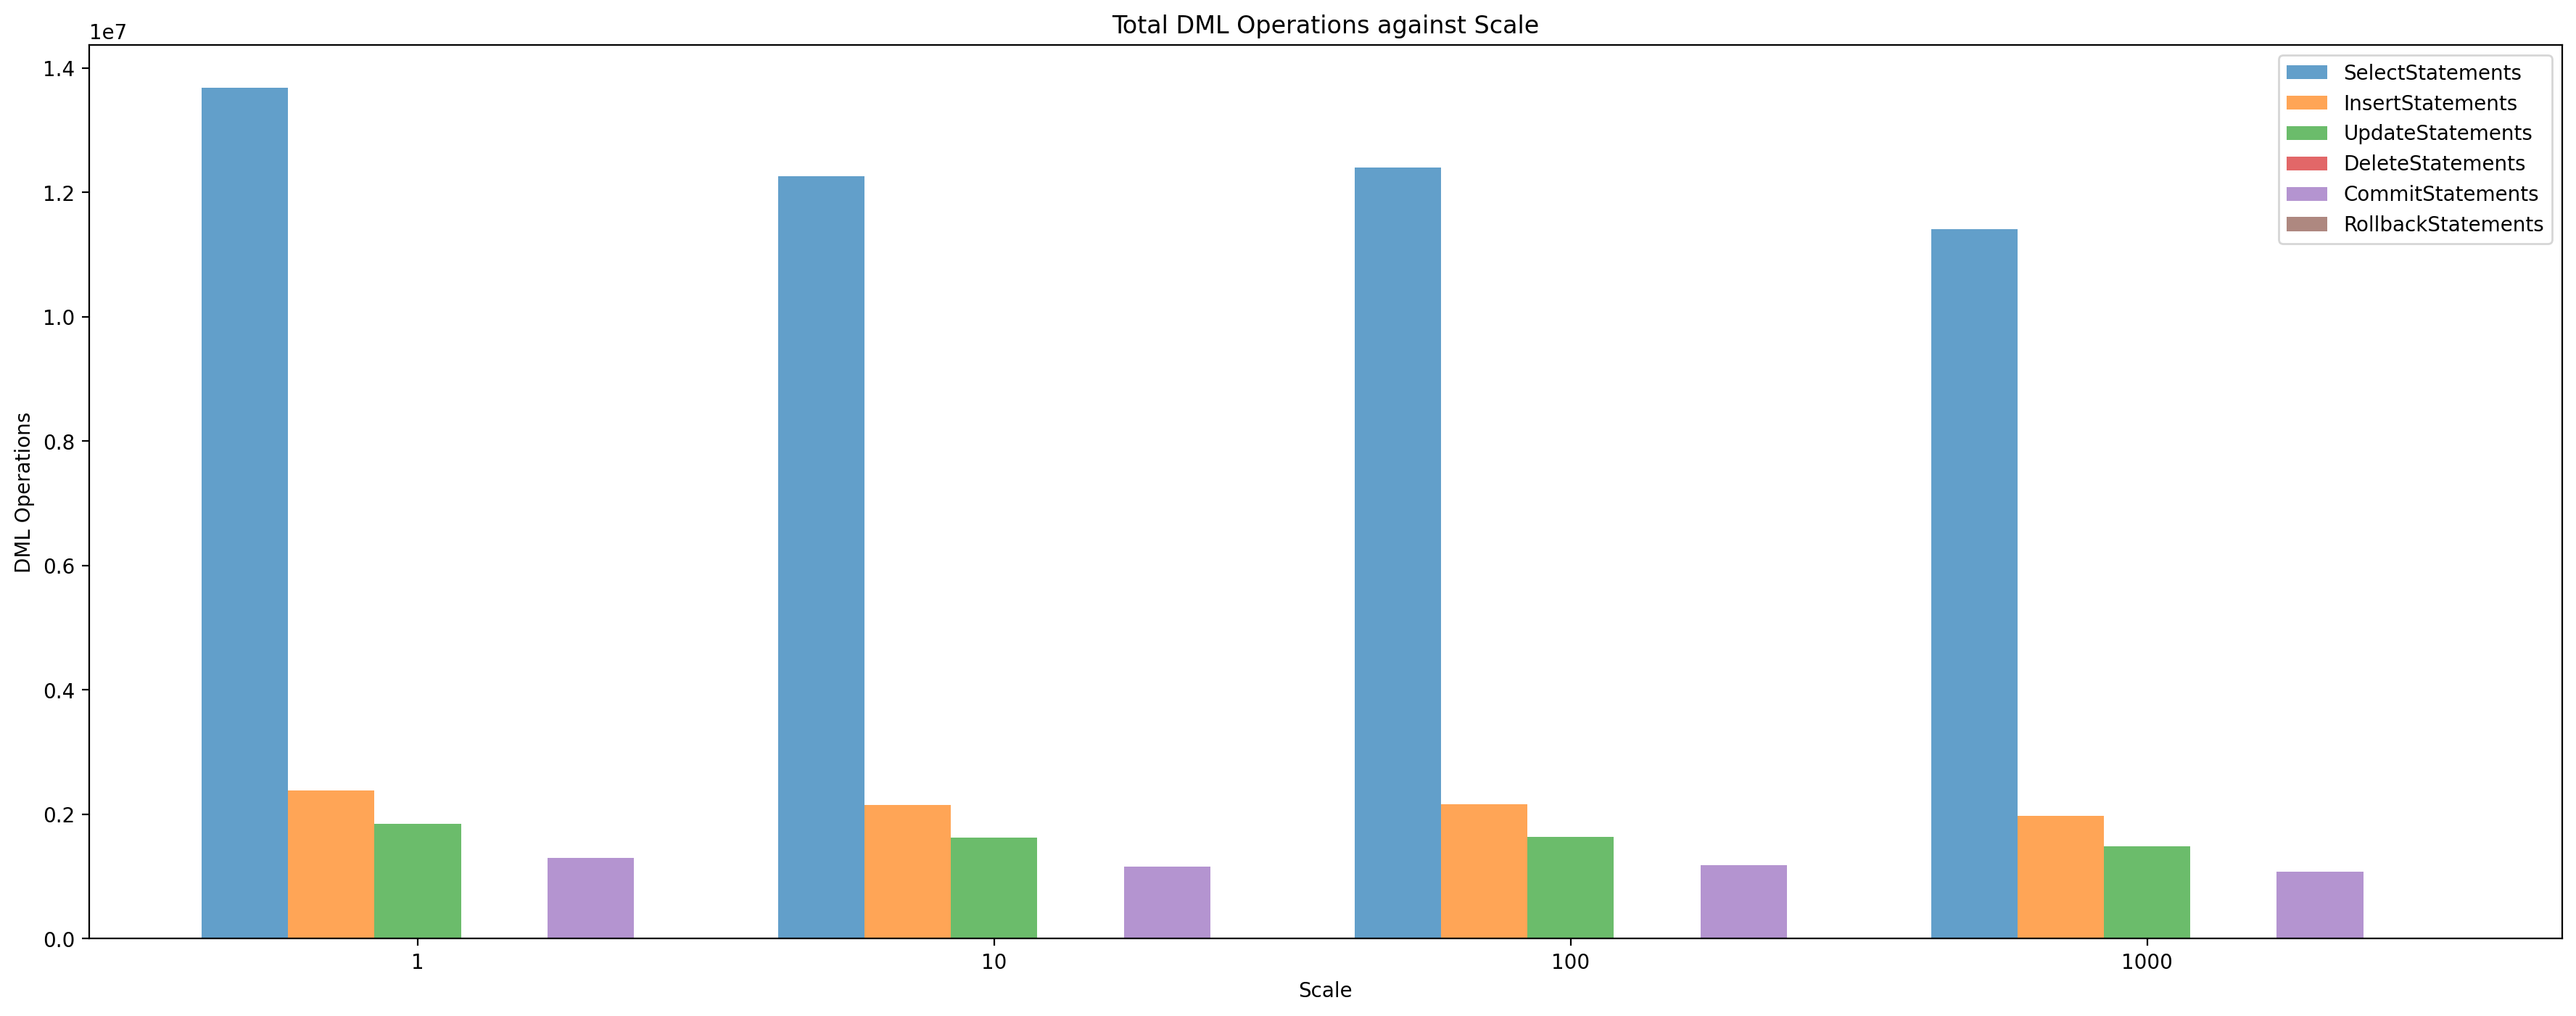

In [19]:
# Get the tags for the Overview Section
val:[ET.Element] = first_doc.findall(f".//{namespace}DMLResults/*")
dml_tags:[str] = [t.tag.split('}', 1)[1] for t in val]

table_values = {"Description": dml_tags}
for file_name, doc in sortedxmldocs.items():
    table_values[file_name] = [int(get_key_value(doc, 'DMLResults', key)) for key in dml_tags]
dml_df = pd.DataFrame(table_values)
dml_df.set_index(['Description'],inplace=True)
display(dml_df)

# Needs to change this to DML/Operations per sec
width = 0.15
index = np.arange(len(measures))
fig, ax = plt.subplots()
fig.set_figwidth(22)
fig.set_figheight(8)
for offset, dml_type in enumerate(dml_tags):
    vals = dml_df.loc[dml_type].astype('int32').values
    rect = ax.bar(index+(width*offset), vals, width, alpha=0.7, label=dml_type)
ax.set_xticks(index + width / 0.5)
ax.set_xlabel(sort_term)
ax.set_ylabel("DML Operations")
ax.set_title(f"Total DML Operations against {sort_term}")
ax.legend()
labels = ax.set_xticklabels(measures)

## Transaction Results

results_scale1_uc64_cpu8_3.xml   
Transaction_id          Result                                                  
Customer Registration   AverageResponse                    13.048787836053384  \
                        MinimumResponse                                     4   
                        MaximumResponse                                   574   
                        GeometricMean                       9.059566988026349   
                        TenthPrecentile                                     5   
                        TwentiethPercentile                                 5   
                        ThirtiethPercentile                                 5   
                        FortiethPrecentile                                  6   
                        FiftythPercentile                                   7   
                        SixtiethPercentile                                  8   
                        SeventiethPercentile                                9   
                        EightiethPercentile                                11   
                        NinetiethPercentile                                14   
                        TransactionCount                               156002   
                        FailedTransactionCount                              0   
                        RollbackCount                                       0   
Update Customer Details AverageResponse                     10.16921478260033   
                        MinimumResponse                                     3   
                        MaximumResponse                                   392   
                        GeometricMean                       6.656109383800352   
                        TenthPrecentile                                     3   
                        TwentiethPercentile                                 3   
                        ThirtiethPercentile                                 3   
                        FortiethPrecentile                                  4   
                        FiftythPercentile                                   5   
                        SixtiethPercentile                                  6   
                        SeventiethPercentile                                7   
                        EightiethPercentile                                 9   
                        NinetiethPercentile                                12   
                        TransactionCount                               103933   
                        FailedTransactionCount                              0   
                        RollbackCount                                       0   
Browse Products         AverageResponse                    10.703181186288063   
                        MinimumResponse                                     3   
                        MaximumResponse                                   418   
                        GeometricMean                       7.255614454755749   
                        TenthPrecentile                                     4   
                        TwentiethPercentile                                 4   
                        ThirtiethPercentile                                 4   
                        FortiethPrecentile                                  4   
                        FiftythPercentile                                   5   
                        SixtiethPercentile                                  6   
                        SeventiethPercentile                                7   
                        EightiethPercentile                                 9   
                        NinetiethPercentile                                12   
                        TransactionCount                               518643   
                        FailedTransactionCount                              0   
                        RollbackCount                                       0 

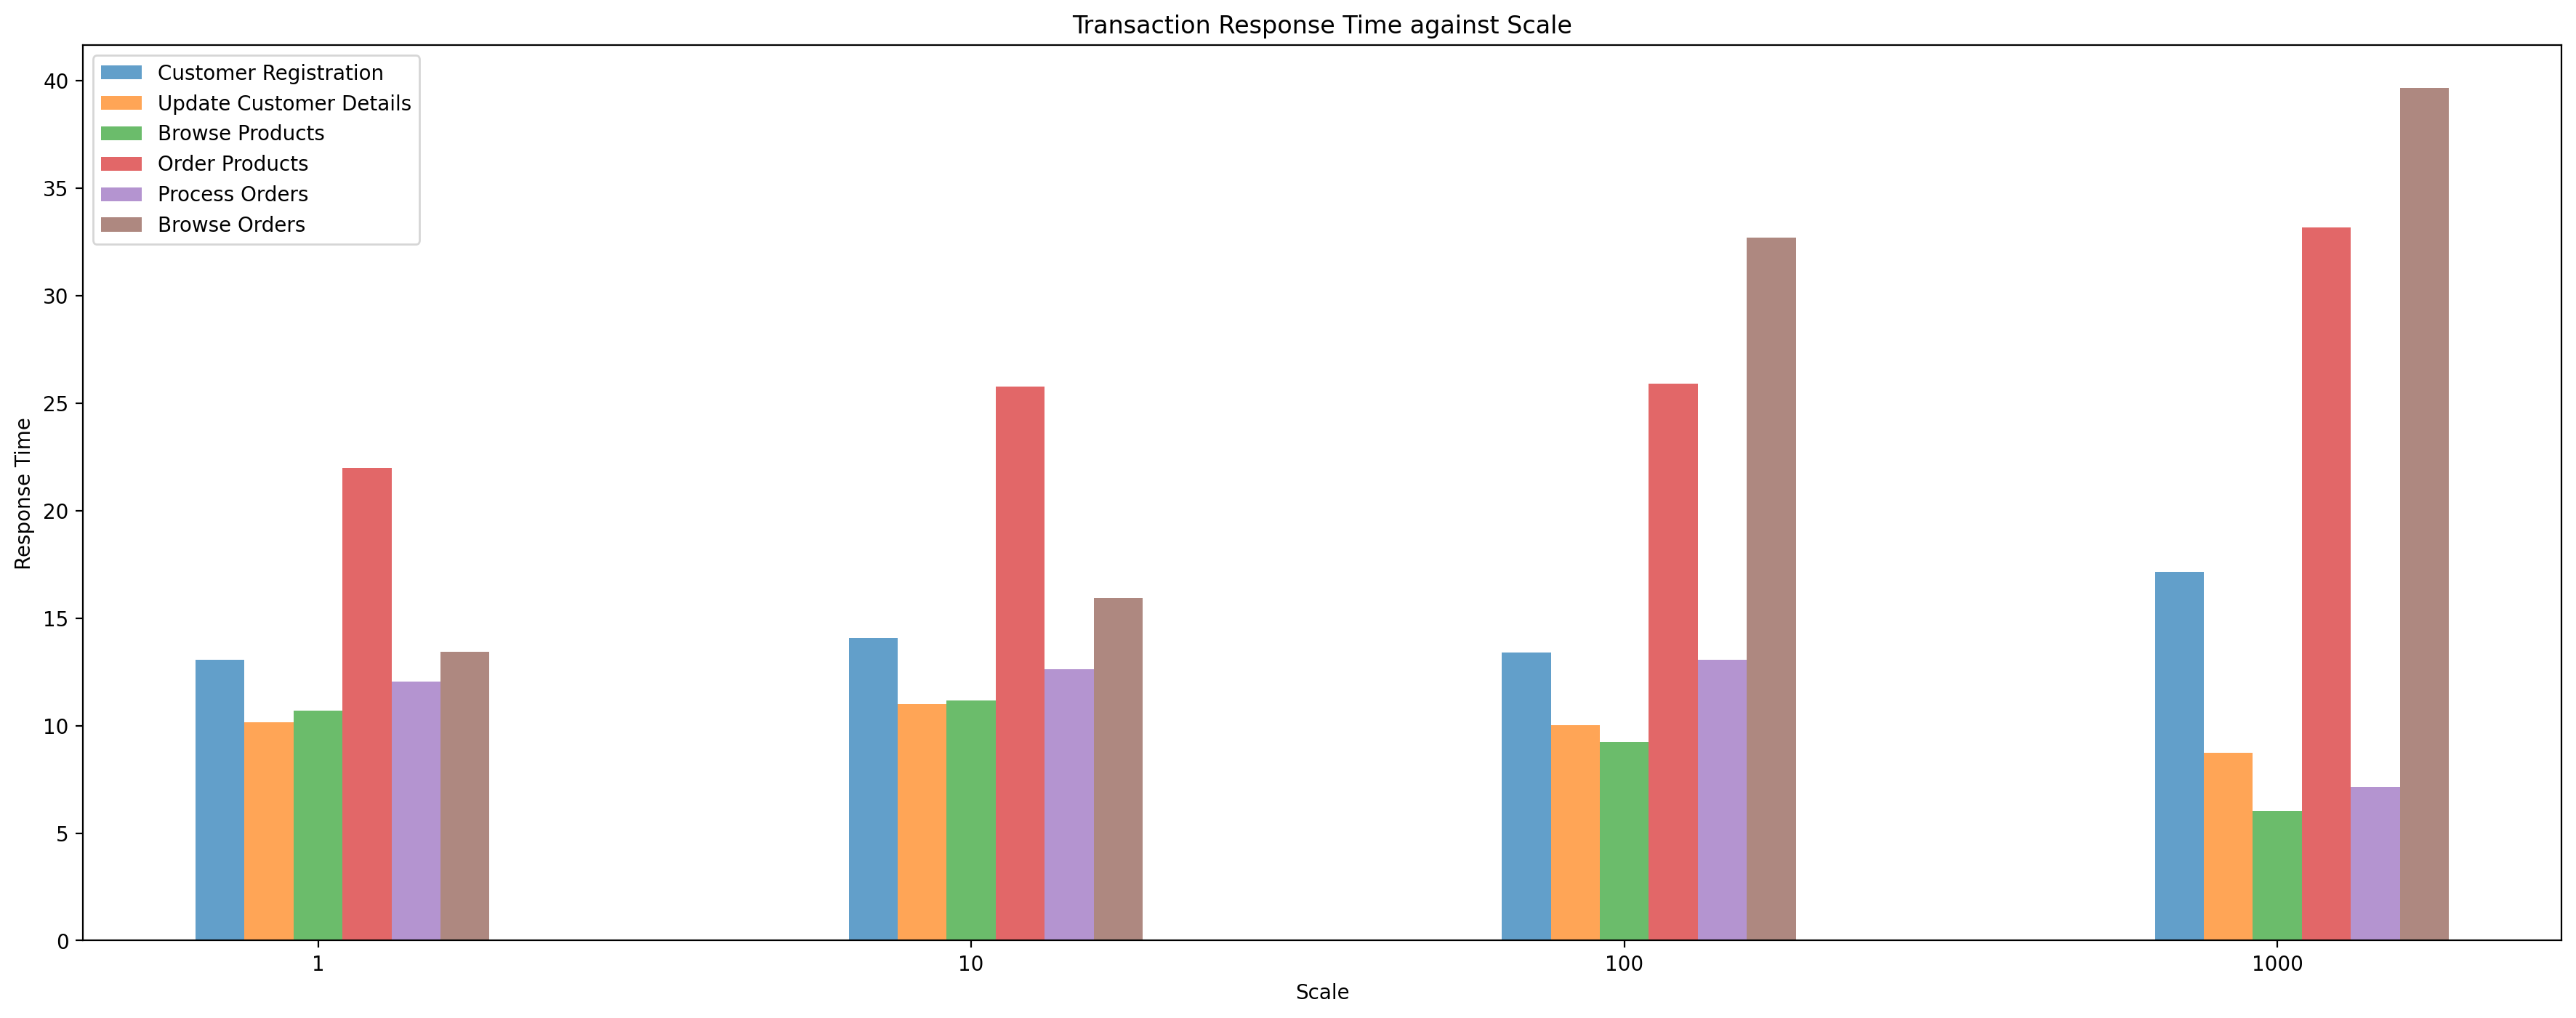

In [20]:
# Get a list of tuples containing the transaction id and result
tx_results:Tuple[str,ET.Element] = [(tx_result.attrib.get('id'),tx_result) for tx_result in first_doc.findall(f'.//{namespace}Result')]
# Get the names of the metrics
val:[ET.Element] = first_doc.findall(f".//*{namespace}Result[@id='{tx_results[0][0]}']/*")
metric_tags:[str] = [t.tag.split('}', 1)[1] for t in val]


df_array = []
for tx_name, tx_result in tx_results:
    file_results = {}
    for file_name, doc in sortedxmldocs.items():
        file_results[file_name] = [get_tx_results(doc, namespace, m , tx_name) for m in metric_tags]
    tx_frame = pd.DataFrame(file_results)
    tx_frame["Result"] = metric_tags
    tx_frame["Transaction_id"] = tx_name
    df_array.append(tx_frame)
df = pd.concat(df_array)
df.set_index(['Transaction_id','Result'], inplace=True)
pd.set_option('display.max_rows', 500)
display(df)

width = 0.075
index = np.arange(len(measures))
fig, ax = plt.subplots()
fig.set_figwidth(22)
fig.set_figheight(8)
for offset,tx_id in enumerate(tx_results):
    vals = df.loc[(tx_id[0],'AverageResponse')].astype('float').values
    rect = ax.bar(index+(width*offset), vals, width, alpha=0.7, label=tx_id[0])
ax.set_xticks(index + width / 0.5)
ax.set_xlabel(sort_term)
ax.set_ylabel("Response Time")
ax.set_title(f"Transaction Response Time against {sort_term}")
ax.legend()
labels = ax.set_xticklabels(measures)

## Database Wait Events
If you've enables database statistics collections the following section will display the wait events for each run and a series of charts.

,results_scale1_uc64_cpu8_3.xml_event,results_scale1_uc64_cpu8_3.xml_value,results_scale10_uc64_cpu8_3.xml_event,results_scale10_uc64_cpu8_3.xml_value,results_scale100_uc64_cpu8_3.xml_event,results_scale100_uc64_cpu8_3.xml_value,results_scale1000_uc64_cpu8_3.xml_event,results_scale1000_uc64_cpu8_3.xml_value
0,resmgr:cpu quantum,61.65,resmgr:cpu quantum,62.90,resmgr:cpu quantum,50.24,cell single block physical read,41.83
1,CPU Time,29.67,CPU Time,28.47,CPU Time,27.28,CPU Time,28.54
2,log file sync,5.01,log file sync,4.40,cell single block physical read: flash cache,10.41,cell single block physical read: flash cache,11.95
3,SQL*Net message to client,1.63,SQL*Net message to client,1.40,log file sync,5.38,resmgr:cpu quantum,10.27
4,buffer busy waits,0.49,cell single block physical read: flash cache,1.29,cell single block physical read,3.59,log file sync,3.68
5,library cache: mutex X,0.32,buffer busy waits,0.44,SQL*Net message to client,1.23,cell list of blocks physical read,2.23
6,cell single block physical read: flash cache,0.30,PGA memory operation,0.23,library cache: mutex X,0.64,library cache: mutex X,0.57
7,PGA memory operation,0.25,library cache: mutex X,0.21,cell list of blocks physical read,0.47,SQL*Net message to client,0.25
8,cursor: mutex X,0.19,cell multiblock physical read,0.20,buffer busy waits,0.16,PGA memory operation,0.25
9,cell multiblock physical read,0.13,cursor: mutex X,0.14,cell multiblock physical read,0.16,cell multiblock physical read,0.11


/var/folders/kc/xx31ryw100bdcfl64wcxfmz40000gn/T/ipykernel_88311/3864444312.py:35: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3, 3, counter)


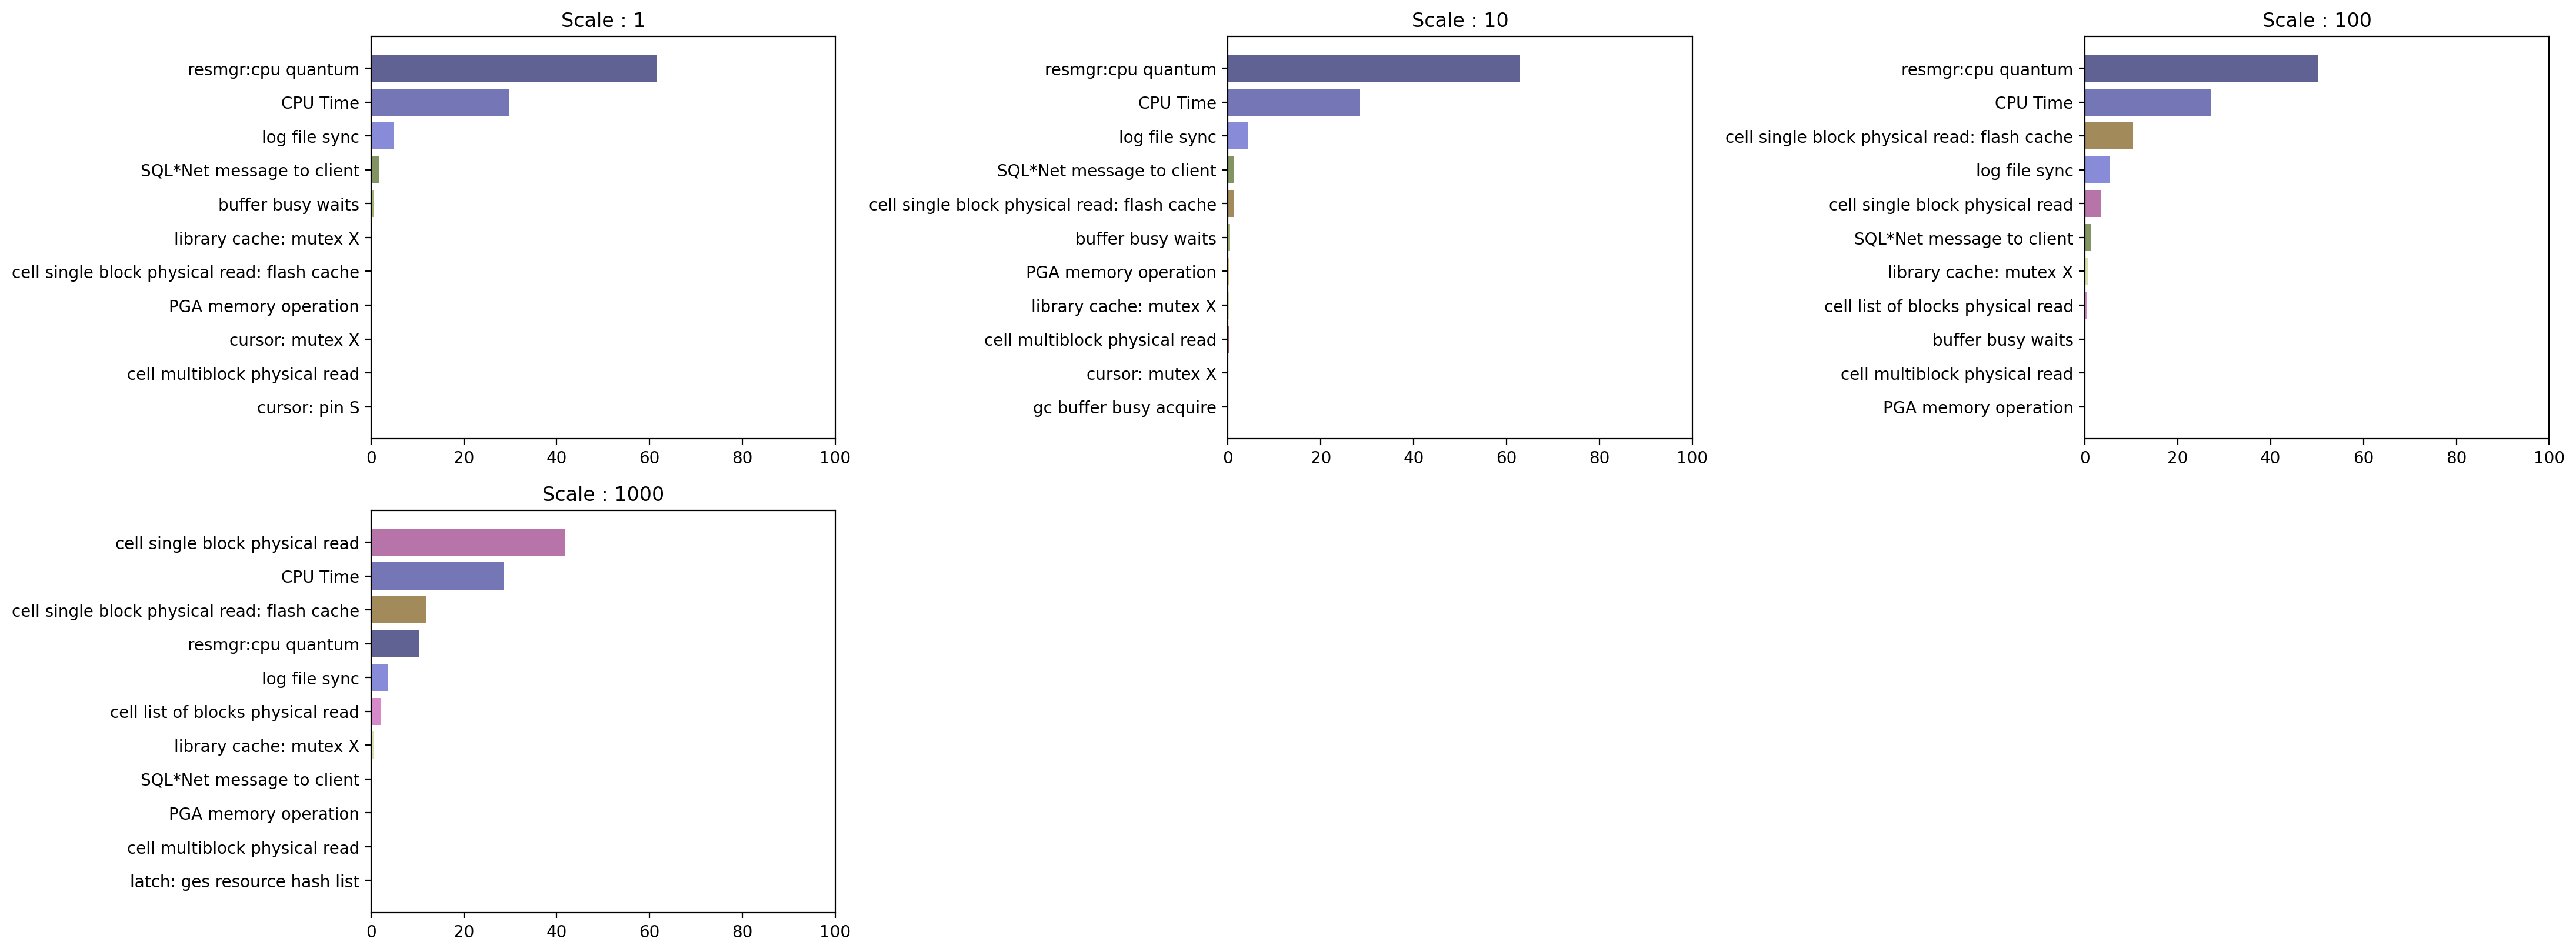

In [21]:
# Collect the data on wait events and print them out in a table
wait_events = {}
for file_name, doc in sortedxmldocs.items():
    wait_event = [(str(tx_result.attrib.get('name')),float(tx_result.attrib.get('percentageTimeWaited'))) for tx_result in doc.findall(f'.//{namespace}DatabaseWaitEvent')]
    res = list(zip(*wait_event)) 
    wait_events[f'{file_name}_event'] = res[0]
    wait_events[f'{file_name}_value'] = res[1]

wait_df = pd.DataFrame(wait_events)
display(wait_df)


# Try and get all of the unique strings for the wait events.
event_name_cols = [col for col in wait_df.columns if 'event' in col]
all_events = pd.concat(pd.Series(wait_df[s]) for s in event_name_cols).unique()

# Map a colour map to the unique number of events
cmap = plt.get_cmap('tab20b')
colors = cmap(np.linspace(0, 1, len(all_events)))

# Map Event names to the colours we've created
persisted_map = {}
for c in zip(all_events, colors):
    persisted_map[c[0]] = c[1]

    
# Plot the wait events
fig, ax = plt.subplots()
fig.set_figwidth(22)
fig.set_figheight(12)
counter = 1
for file_name, doc in sortedxmldocs.items():
    # Create a color array mapping names to colours
    event_colours = [persisted_map[x] for x in wait_df[f'{file_name}_event']]
    ax = plt.subplot(3, 3, counter)
    plt.barh(y=wait_df[f'{file_name}_event'],width=wait_df[f'{file_name}_value'],alpha=0.8,color=event_colours)
    ax.set_title(f'{sort_term} : {sort_function(file_name)}')
    ax.set_xlim(0,100)
    ax.invert_yaxis()
    plt.tight_layout()
    counter += 1
                                                    


## Database Statistics
If database statisitics are collected then they'll be displayed below. It's likely that you won't get the same number of stats back from the database for each run so there maybe a few discprencies when comparing.

In [31]:
db_stats = {}
for file_name, doc in sortedxmldocs.items():
    db_stat = [(dbs.attrib.get('name'),dbs.attrib.get('value')) for dbs in doc.findall(f'.//{namespace}DatabaseStatistic')]
    db_stats[f'{file_name}_name'], db_stats[f'{file_name}_value'] = list(zip(*db_stat))

# Join all the results from the file togther knowing that theymight not all have the same stats
dbs_df = pd.concat([pd.Series(v, name=k) for k, v in db_stats.items()], axis=1)
dbs_df


,results_scale100_uc16_cpu1.xml_name,results_scale100_uc16_cpu1.xml_value,results_scale100_uc32_cpu2.xml_name,results_scale100_uc32_cpu2.xml_value,results_scale100_uc64_cpu4.xml_name,results_scale100_uc64_cpu4.xml_value,results_scale100_uc128_cpu8.xml_name,results_scale100_uc128_cpu8.xml_value
0,scheduler wait time,42723,scheduler wait time,120903,scheduler wait time,161717,scheduler wait time,979984
1,redo synch time (usec),81840877,redo synch time (usec),194661444,redo synch time (usec),471382170,redo synch time (usec),1022049053
2,physical reads,623422,physical reads,1020867,physical reads,1769382,physical reads,2049979
3,Batched IO block miss count,21381,Batched IO block miss count,36967,Batched IO block miss count,61269,Batched IO block miss count,63528
4,ASSM gsp:get free block,283183,ASSM gsp:get free block,526853,ASSM gsp:get free block,1087220,ASSM gsp:get free block,1591969
5,global enqueue gets sync,834823,cursor reload failures,1,global enqueue gets sync,3209868,global enqueue gets sync,4732450
6,txn cache remote requested xid count,503,global enqueue gets sync,1553460,txn cache remote requested xid count,1375,txn cache remote requested xid count,67
7,KTFB alloc req,73,txn cache remote requested xid count,852,KTFB alloc req,111,KTFB alloc req,289
8,no work - consistent read gets,16635792,no work - consistent read gets,33210642,no work - consistent read gets,75208251,no work - consistent read gets,120772761
9,ASSM gsp:L1 bitmaps examined,283541,ASSM gsp:L1 bitmaps examined,527090,ASSM gsp:L1 bitmaps examined,1088108,ASSM gsp:L1 bitmaps examined,1594363
